In [1]:
from torch import nn
import torch
from dcgan import Generator, Discriminator, weights_init
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as tvutils

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
# Variables that are required for data loading
img_size = 64
batch_size = 32
num_workers = 2

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
# Create a dataloader for our images. We use torchvision.datasets.ImageFolder
dataset = datasets.ImageFolder(
    root="/workspaces/DCGANs/celeba",
    transform=transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

# Question : Why do we need to Normalize the images to mean of 0.5 and std dev of 0.5 using the transform above. Does it help with the training of the GANs? Is it given in the paper?
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

real_batch = next(iter(dataloader))


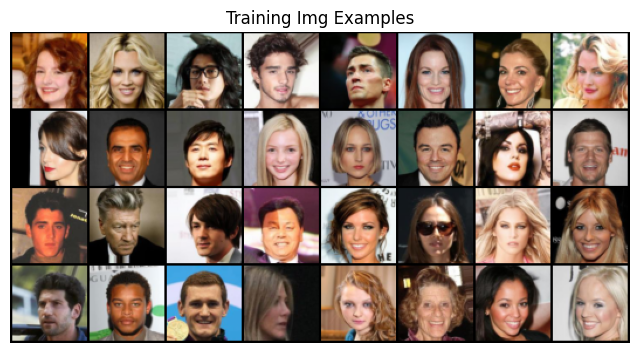

In [5]:
plt.figure(figsize=(8,8 ))
plt.axis("off")
plt.title("Training Img Examples")
plt.imshow(np.transpose(tvutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [6]:
zdim = 100
ngpu = 1

lr = 0.0002
beta1 = 0.5

In [7]:
device

device(type='cpu')

In [8]:
GNet = Generator()
DNet = Discriminator()

In [9]:
GNet.apply(weights_init)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [10]:
DNet.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
# Loss function used for Discriminator and Generation is Binary Cross Entropy loss
criterion = nn.BCELoss()

In [12]:
# this is the fixed noise generated from a Gaussian distribution fed to our Generator periodically 
# basically generator eventually generates images out of this noise vector and these images are then classified by Discriminator as real or fake
fixed_noise = torch.randn(64, zdim, 1, 1, device=device)

In [13]:
REAL_LABEL = 1
FAKE_LABEL = 0
# size of latent vector
nz = 100 

In [14]:
optimizerD = torch.optim.Adam(GNet.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(DNet.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training variables
num_epochs = 5

In [17]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train D with all-real batch
        DNet.zero_grad()
        
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # generate real labels tensor
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = DNet(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train D with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = GNet(noise)
        label.fill_(FAKE_LABEL)
        # Classify all fake batch with D 
        # NOTE : don't know if we need to detach fake before giving to DNet??
        # output = DNet(fake.detach()).view(-1)
        output = DNet(fake).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        print(f'Discriminator backprop done Epoch {epoch}')

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        GNet.zero_grad()
        label.fill_(REAL_LABEL)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = DNet(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        print(f'Generator backprop done Epoch {epoch}')

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = GNet(fixed_noise).detach().cpu()
            img_list.append(tvutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
